# Credit Risk Dataset

# Dicionário

Person_age: Idade.

Person_income: Renda Anual.

Person_home_ownership: Propriedade da casa.

Person_emp_length: Duração do emprego (em anos).

Loan_intent: Intenção de empréstimo.

Loan_grade: Grau de risco do empréstimo.

Loan_amnt: Valor do empréstimo.

Loan_int_rate: Taxa de juro.

Loan_status: Status do empréstimo (0 é não inadimplente, 1 é inadimplente).

Loan_percent_income: Renda percentual.

Cb_person_default_on_file: Inadimplência histórica.

Cb_person_cred_hist_length: Duração do histórico de crédito.

In [34]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import miceforest as mf
from scipy import stats
from fancyimpute import KNN
from scipy.stats import chi2_contingency

In [35]:
df = pd.read_csv("credit_risk_dataset.csv", encoding="ISO-8859-1") # Abre o arquivo .csv.

In [36]:
con = sqlite3.connect("projetocredito.db") # Cria um banco de dados SQLite.

In [37]:
cursor = con.cursor() # Armazena o cursor.

In [38]:
df.to_sql("credit_risk_dataset", con, if_exists="replace", index=False) # Salva o DataFrame em uma tabela do banco de dados.

32581

In [39]:
df_geral = pd.read_sql_query("""
    SELECT *
    FROM credit_risk_dataset
""", con) # Cria um novo DataFrame e armazena a consulta SQL. 

df_geral.head() # Apresenta o DataFrame. 

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [40]:
# Seleciona apenas algumas colunas.
colunas_selecionadas = ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 
 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length'] # Define quais colunas considerar.

df_geral_main = df_geral[colunas_selecionadas] # Gera um novo DataFrame apenas com as colunas selecionadas.

df_geral_main.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [41]:
coluna_transicao = {
    'person_age': 'Idade',
    'person_income': 'Renda_Anual', 
    'person_home_ownership': 'Status_Propriedade_Imovel',
    'person_emp_length': 'Permanencia_Emprego',
    'loan_intent': 'Modalidade_Credito',
    'loan_grade': 'Nivel_Risco',
    'loan_amnt': 'Valor_Emprestimo',
    'loan_int_rate': 'Taxa_Juros',
    'loan_status': 'Status_Inadimplencia_Emprestimo',
    'loan_percent_income': 'Percentual_Renda_Comprometida',
    'cb_person_default_on_file': 'Inadimplencia_Historica',
    'cb_person_cred_hist_length': 'Extensao_Historico_Credito',
    
} # Cria um dicionário em que key: nomeclatura em inglês e value: nomenclatura em português.

In [42]:
# Renomeia as colunas utilizando o dicionário column_translation.
df_geral_main.rename(columns = coluna_transicao, inplace = True)

# Verifica as primeiras linhas do DataFrame para confirmar as alterações.
df_geral_main.head(5)

,Idade,Renda_Anual,Status_Propriedade_Imovel,Permanencia_Emprego,Modalidade_Credito,Nivel_Risco,Valor_Emprestimo,Taxa_Juros,Status_Inadimplencia_Emprestimo,Percentual_Renda_Comprometida,Inadimplencia_Historica,Extensao_Historico_Credito
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [43]:
df_geral_main.info() # Traz informações gerais sobre as colunas.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Idade                            32581 non-null  int64  
 1   Renda_Anual                      32581 non-null  int64  
 2   Status_Propriedade_Imovel        32581 non-null  object 
 3   Permanencia_Emprego              31686 non-null  float64
 4   Modalidade_Credito               32581 non-null  object 
 5   Nivel_Risco                      32581 non-null  object 
 6   Valor_Emprestimo                 32581 non-null  int64  
 7   Taxa_Juros                       29465 non-null  float64
 8   Status_Inadimplencia_Emprestimo  32581 non-null  int64  
 9   Percentual_Renda_Comprometida    32581 non-null  float64
 10  Inadimplencia_Historica          32581 non-null  object 
 11  Extensao_Historico_Credito       32581 non-null  int64  
dtypes: float64(3), int

In [44]:
df_geral_main['Status_Inadimplencia_Emprestimo'] = df_geral_main['Status_Inadimplencia_Emprestimo'].astype('object') # Altera o formato da coluna 'Status_emprestimo' de int64 para object.

In [45]:
# Remove duplicatas.
df_geral_main = df_geral_main.drop_duplicates()

In [46]:
valores_unicos = sorted(df_geral_main['Permanencia_Emprego'].unique(), reverse=True) # Apresenta os valores únicos da coluna 'Duracao_do_emprego' em ordem decrescente.
print(valores_unicos)

[np.float64(123.0), np.float64(nan), np.float64(41.0), np.float64(38.0), np.float64(34.0), np.float64(31.0), np.float64(30.0), np.float64(29.0), np.float64(28.0), np.float64(27.0), np.float64(26.0), np.float64(25.0), np.float64(24.0), np.float64(23.0), np.float64(22.0), np.float64(21.0), np.float64(20.0), np.float64(19.0), np.float64(18.0), np.float64(17.0), np.float64(16.0), np.float64(15.0), np.float64(14.0), np.float64(13.0), np.float64(12.0), np.float64(11.0), np.float64(10.0), np.float64(9.0), np.float64(8.0), np.float64(7.0), np.float64(6.0), np.float64(5.0), np.float64(4.0), np.float64(3.0), np.float64(2.0), np.float64(1.0), np.float64(0.0)]


In [47]:
df_geral_main['Permanencia_Emprego'] = df_geral_main['Permanencia_Emprego'].replace(123.0, 41.0) # Substitui o valor '123.0' pelo penúltimo valor mais alto '41.0' e elimina o outlier.

In [48]:
def corrigir_duracao_emprego(df):
    # Aplica a correção com base na condição
    df_geral_main['Permanencia_Emprego_Corrigida'] = df.apply(lambda row: 
        max(row['Idade'] - 14, 0) if (row['Idade'] - row['Permanencia_Emprego']) < 14 else row['Permanencia_Emprego'], axis=1)
    return df_geral_main

In [49]:
df_geral_main = corrigir_duracao_emprego(df_geral_main)
df_geral_main.head()

,Idade,Renda_Anual,Status_Propriedade_Imovel,Permanencia_Emprego,Modalidade_Credito,Nivel_Risco,Valor_Emprestimo,Taxa_Juros,Status_Inadimplencia_Emprestimo,Percentual_Renda_Comprometida,Inadimplencia_Historica,Extensao_Historico_Credito,Permanencia_Emprego_Corrigida
0,22,59000,RENT,41.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,8.0
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,5.0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,1.0
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2,4.0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4,8.0


In [50]:
df_geral_main = df_geral_main.drop('Permanencia_Emprego', axis=1)

In [51]:
df_geral_main = df_geral_main.rename(columns={'Permanencia_Emprego_Corrigida': 'Permanencia_Emprego'})

In [52]:
df_geral_main.head()

,Idade,Renda_Anual,Status_Propriedade_Imovel,Modalidade_Credito,Nivel_Risco,Valor_Emprestimo,Taxa_Juros,Status_Inadimplencia_Emprestimo,Percentual_Renda_Comprometida,Inadimplencia_Historica,Extensao_Historico_Credito,Permanencia_Emprego
0,22,59000,RENT,PERSONAL,D,35000,16.02,1,0.59,Y,3,8.0
1,21,9600,OWN,EDUCATION,B,1000,11.14,0,0.10,N,2,5.0
2,25,9600,MORTGAGE,MEDICAL,C,5500,12.87,1,0.57,N,3,1.0
3,23,65500,RENT,MEDICAL,C,35000,15.23,1,0.53,N,2,4.0
4,24,54400,RENT,MEDICAL,C,35000,14.27,1,0.55,Y,4,8.0


In [53]:
df_geral_main.isna().sum() # Contabiliza o número de nulos de cada coluna.

Idade                                 0
Renda_Anual                           0
Status_Propriedade_Imovel             0
Modalidade_Credito                    0
Nivel_Risco                           0
Valor_Emprestimo                      0
Taxa_Juros                         3095
Status_Inadimplencia_Emprestimo       0
Percentual_Renda_Comprometida         0
Inadimplencia_Historica               0
Extensao_Historico_Credito            0
Permanencia_Emprego                 887
dtype: int64

# Tratamento de Outliers

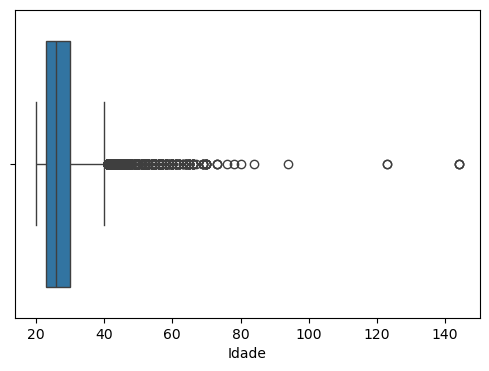

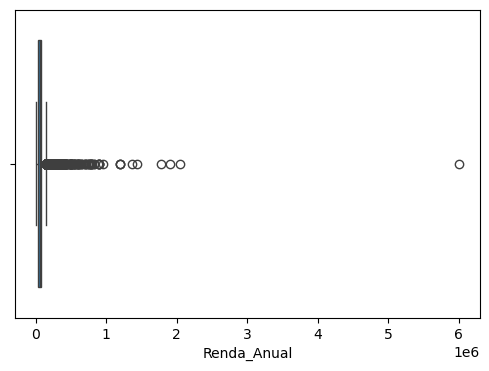

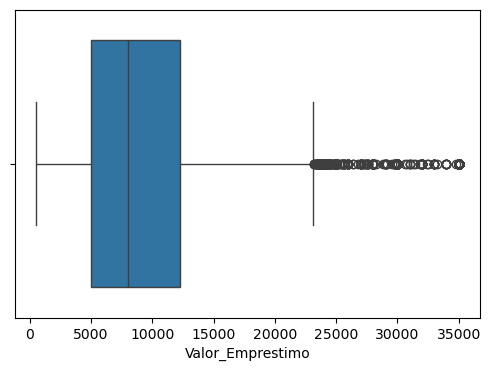

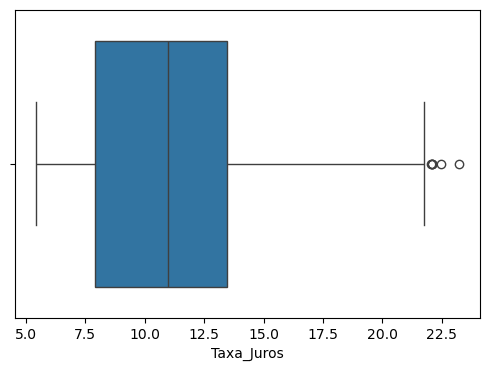

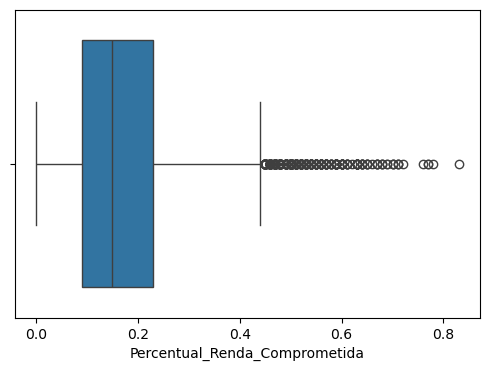

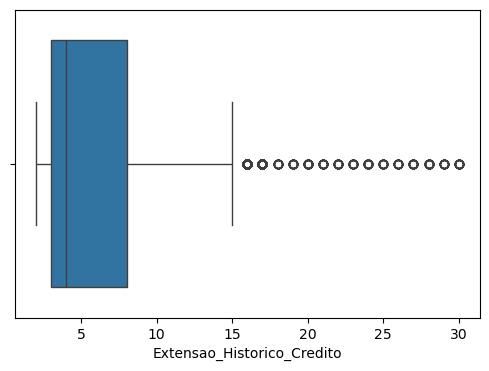

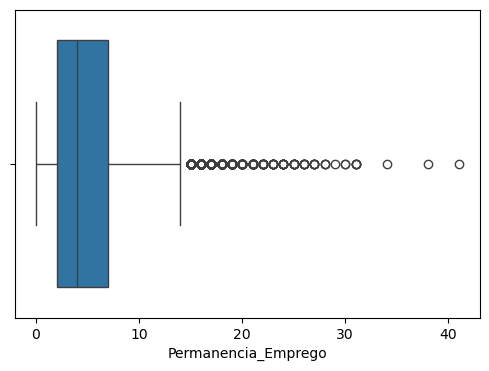

In [54]:
for col in df_geral_main.select_dtypes(include=np.number).columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_geral_main[col])
    plt.show() # Cria gráficos de boxplot.

In [55]:
# Seleciona apenas as colunas numéricas.
df_numericas = df_geral_main.select_dtypes(include="number")

# Calcula o IQR.
Q1 = df_numericas.quantile(0.25)
Q3 = df_numericas.quantile(0.75)
IQR = Q3 - Q1

# Filtra os outliers para as colunas numéricas.
df_geral_main = df_geral_main[~((df_numericas < (Q1 - 1.5 * IQR)) | (df_numericas > (Q3 + 1.5 * IQR))).any(axis=1)]

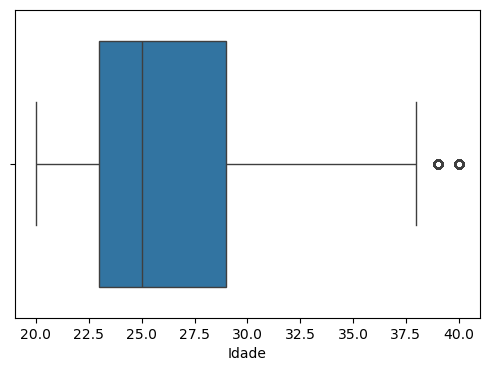

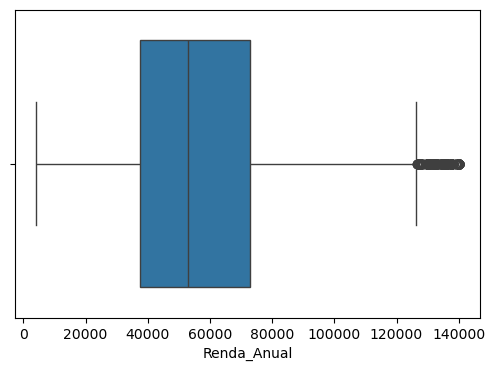

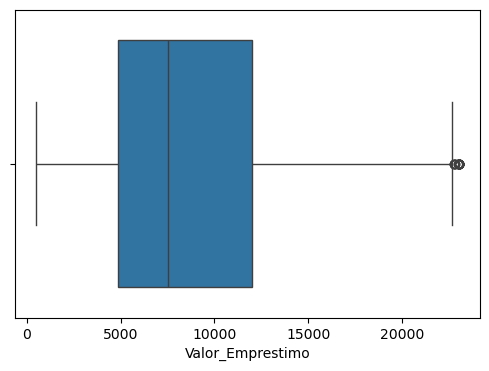

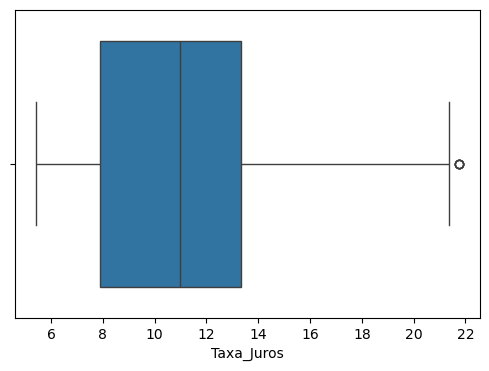

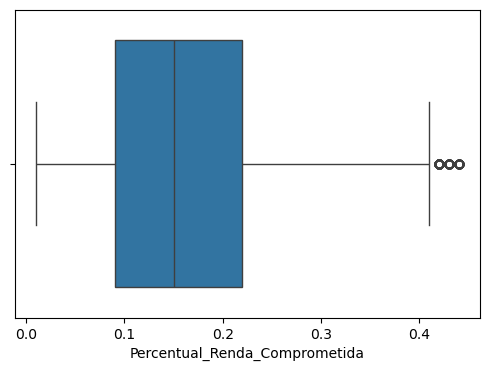

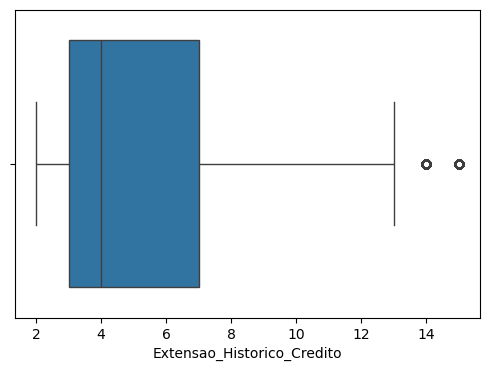

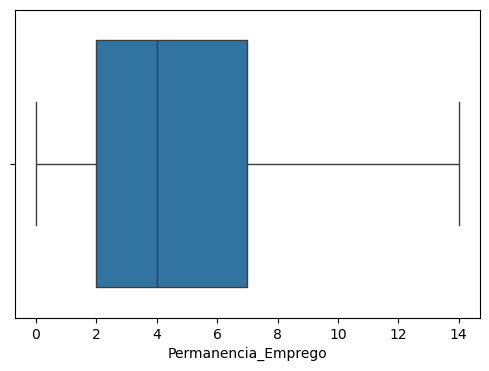

In [56]:
for col in df_geral_main.select_dtypes(include=np.number).columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df_geral_main[col])
    plt.show() # Cria gráficos de boxplot.

# Tratamento dos Nulos

## Verificando a condição dos nulos como Missing at random (MAR) para a coluna 'Duracao_Emprego'

In [57]:
# Crian a variável binária para indicar a ausência de 'Duracao_do_emprego'.
df_geral_main['A_missing'] = df_geral_main['Permanencia_Emprego'].isnull().astype(int)

# Seleciona apenas variáveis numéricas para o teste t.
numeric_vars = df_geral_main.select_dtypes(include=['number']).columns.drop(['Permanencia_Emprego', 'A_missing'])

# Aplica o teste t para cada variável numérica.
results = {}
for var in numeric_vars:
    group_with_missing = df_geral_main[var][df_geral_main['A_missing'] == 1]
    group_without_missing = df_geral_main[var][df_geral_main['A_missing'] == 0]
    
    # Verifica se ambos os grupos têm valores suficientes para o teste.
    if len(group_with_missing) > 1 and len(group_without_missing) > 1:
        t_stat, p_value = stats.ttest_ind(group_with_missing, group_without_missing, nan_policy='omit')
        results[var] = p_value
    else:
        results[var] = np.nan # Caso não haja dados suficientes.

# Exibe os p-valores para cada variável testada.
for var, p_value in results.items():
    print(f'Teste t para {var} - p-valor: {p_value}')

Teste t para Idade - p-valor: 0.7322217492235663
Teste t para Renda_Anual - p-valor: 2.8133785838244887e-69
Teste t para Valor_Emprestimo - p-valor: 9.319328644387274e-34
Teste t para Taxa_Juros - p-valor: 6.498419467949881e-16
Teste t para Percentual_Renda_Comprometida - p-valor: 1.8183269102523273e-06
Teste t para Extensao_Historico_Credito - p-valor: 0.316177383007325


In [58]:
# Cria a variável binária para indicar a ausência de 'Duracao_do_emprego'.
df_geral_main['A_missing'] = df_geral_main['Permanencia_Emprego'].isnull().astype(int)

# Lista para armazenar os resultados.
results = {}

# Seleciona colunas categóricas para o teste (excluindo 'A_missing').
categorical_vars = df_geral_main.select_dtypes(include=['object', 'category']).columns

# Aplica o teste qui-quadrado para cada variável categórica.
for var in categorical_vars:
    contingency_table = pd.crosstab(df_geral_main['A_missing'], df_geral_main[var])
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
    results[var] = p_value

# Exibe os p-valores para cada variável testada.
for var, p_value in results.items():
    print(f'Teste Qui-quadrado para {var} - p-valor: {p_value}')

Teste Qui-quadrado para Status_Propriedade_Imovel - p-valor: 8.290286869615949e-32
Teste Qui-quadrado para Modalidade_Credito - p-valor: 0.9106811878371517
Teste Qui-quadrado para Nivel_Risco - p-valor: 3.573813074735817e-11
Teste Qui-quadrado para Status_Inadimplencia_Emprestimo - p-valor: 6.486911917027439e-11
Teste Qui-quadrado para Inadimplencia_Historica - p-valor: 0.001290299377561909


## Verificando a condição dos nulos como Missing not at Random (MNAR) para a coluna 'Duracao_Emprego'

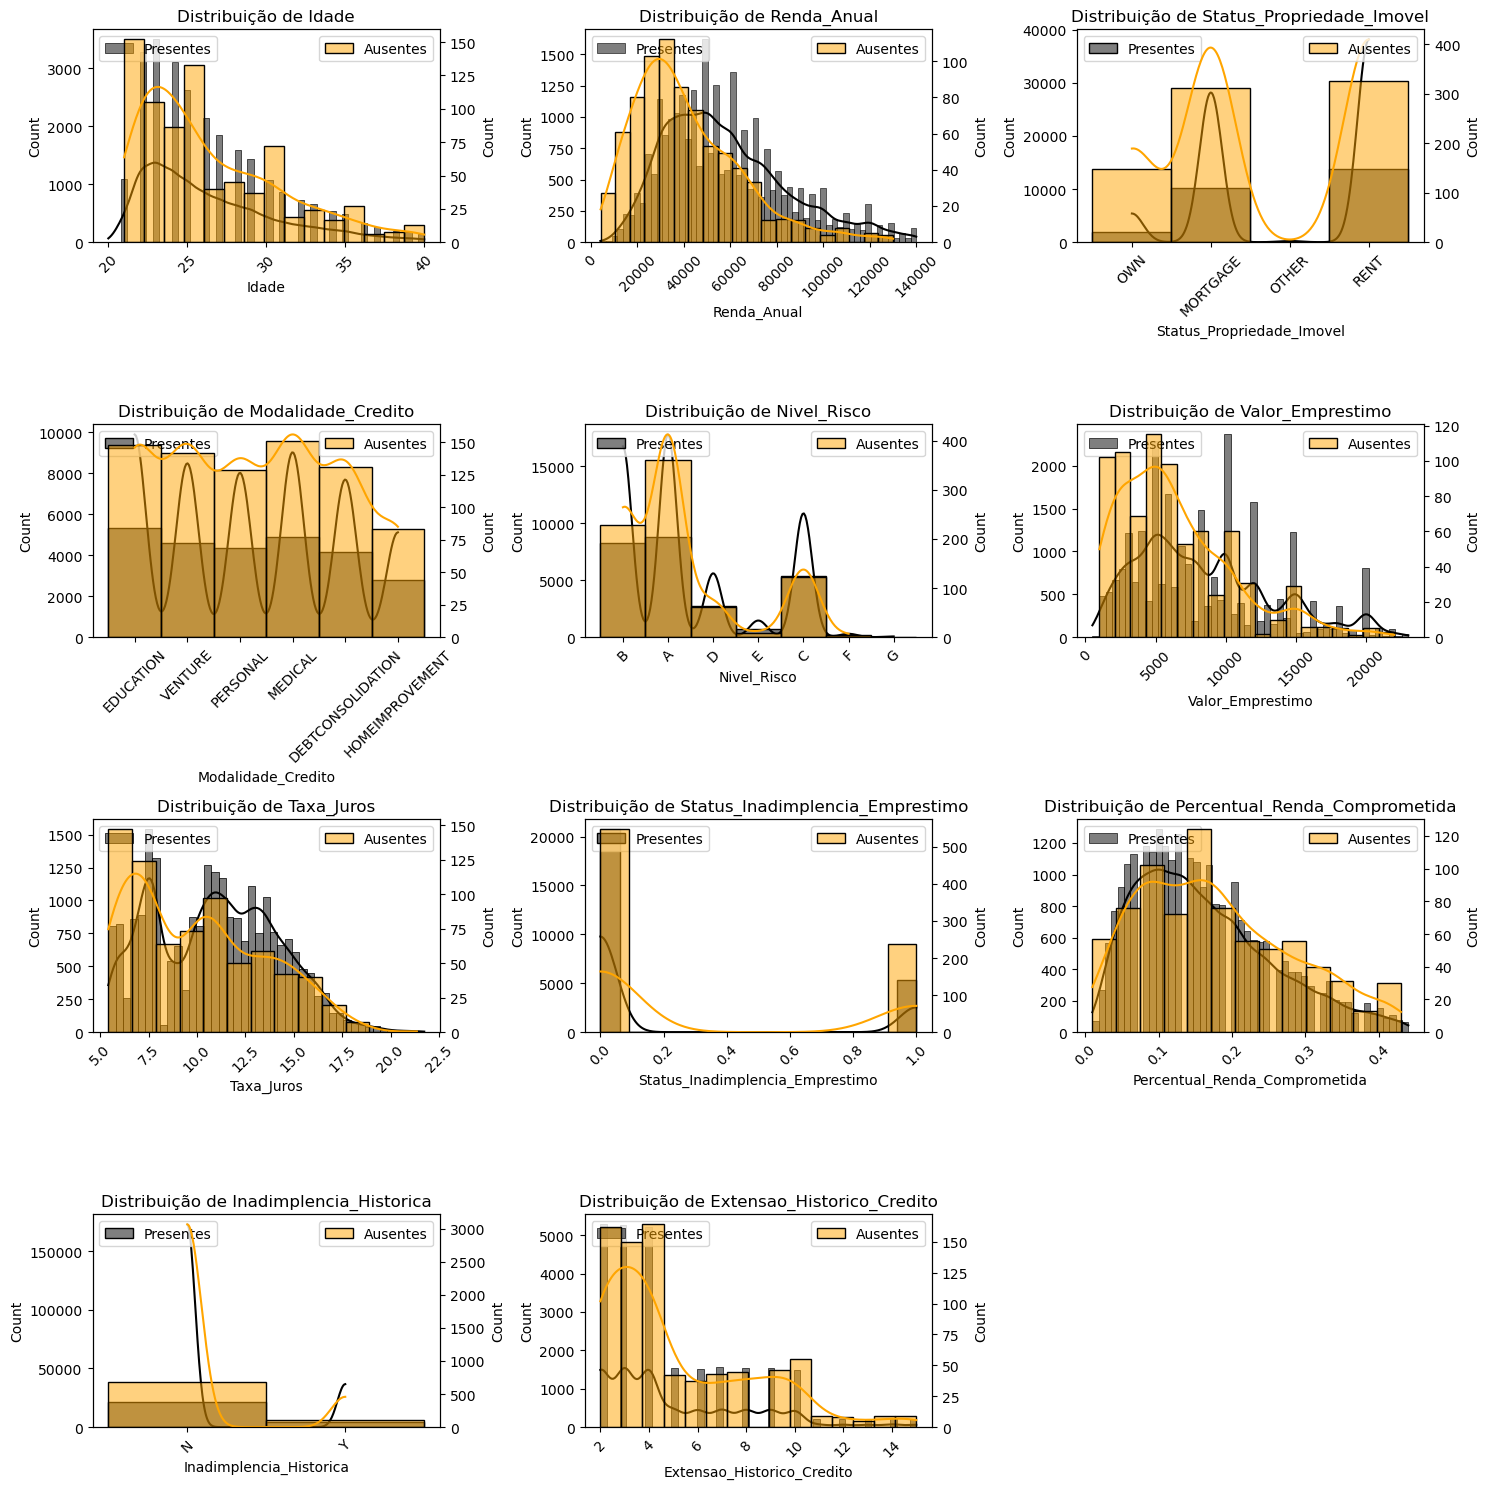

In [60]:
# Lista das variáveis a serem avaliadas.
vars_to_compare = ['Idade', 'Renda_Anual', 'Status_Propriedade_Imovel', 'Modalidade_Credito', 'Nivel_Risco', 'Valor_Emprestimo', 'Taxa_Juros', 'Status_Inadimplencia_Emprestimo', 'Percentual_Renda_Comprometida', 'Inadimplencia_Historica', 'Extensao_Historico_Credito']

# Define a figura e a grade de subgráficos.
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15)) 
axes = axes.flatten() # Torna o array de eixos unidimensional para facilitar o uso no loop.

# Remove o último eixo (para que fiquem 2 gráficos na última linha).
fig.delaxes(axes[-1])

# Loop para plotar as distribuições de cada variável.
for i, var in enumerate(vars_to_compare):
    if i < len(axes): # Verifica se há eixos suficientes.
        # Cria o primeiro eixo Y para a distribuição de 'A_missing == 0' (dados presentes).
        sns.histplot(df_geral_main[var][df_geral_main['A_missing'] == 0], kde=True, ax=axes[i], color='black', label='Presentes')
        axes[i].set_title(f'Distribuição de {var}')
        axes[i].legend(loc='upper left')

        # Cria o segundo eixo Y para a distribuição de 'A_missing == 1' (dados ausentes).
        ax2 = axes[i].twinx() # Cria o eixo Y secundário.
        sns.histplot(df_geral_main[var][df_geral_main['A_missing'] == 1], kde=True, ax=ax2, color='orange', label='Ausentes')
        ax2.legend(loc='upper right')

        # Gira as labels do eixo X.
        axes[i].tick_params(axis='x', rotation=45)

# Ajusta o layout para não sobrepor os gráficos.
plt.tight_layout()
plt.show()

## Verificando a condição dos nulos como Missing at Random (MAR) para a coluna 'Taxa_Juros'

In [61]:
# Cria a variável binária para indicar a ausência de 'Taxa_juros'.
df_geral_main['B_missing'] = df_geral_main['Taxa_Juros'].isnull().astype(int)

# Seleciona apenas variáveis numéricas para o teste t.
numeric_vars = df_geral_main.select_dtypes(include=['number']).columns.drop(['Taxa_Juros', 'B_missing'])

# Aplica o teste t para cada variável numérica.
results = {}
for var in numeric_vars:
    group_with_missing = df_geral_main[var][df_geral_main['B_missing'] == 1]
    group_without_missing = df_geral_main[var][df_geral_main['B_missing'] == 0]
    
    # Verifica se ambos os grupos têm valores suficientes para o teste.
    if len(group_with_missing) > 1 and len(group_without_missing) > 1:
        t_stat, p_value = stats.ttest_ind(group_with_missing, group_without_missing, nan_policy='omit')
        results[var] = p_value
    else:
        results[var] = np.nan # Caso não haja dados suficientes.

# Exibe os p-valores para cada variável testada.
for var, p_value in results.items():
    print(f'Teste t para {var} - p-valor: {p_value}')

Teste t para Idade - p-valor: 0.8418807462279055
Teste t para Renda_Anual - p-valor: 0.05378038032593211
Teste t para Valor_Emprestimo - p-valor: 0.25080984920369687
Teste t para Percentual_Renda_Comprometida - p-valor: 0.6007158490563496
Teste t para Extensao_Historico_Credito - p-valor: 0.8096635072175391
Teste t para Permanencia_Emprego - p-valor: 0.4693120052453532
Teste t para A_missing - p-valor: 0.07637105721629737


In [62]:
# Cria a variável binária para indicar a ausência de 'Taxa_juros'.
df_geral_main['B_missing'] = df_geral_main['Taxa_Juros'].isnull().astype(int)

# Lista para armazenar os resultados.
results = {}

# Seleciona colunas categóricas para o teste (excluindo 'B_missing').
categorical_vars = df_geral_main.select_dtypes(include=['object', 'category']).columns

# Aplica o teste qui-quadrado para cada variável categórica.
for var in categorical_vars:
    contingency_table = pd.crosstab(df_geral_main['B_missing'], df_geral_main[var])
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
    results[var] = p_value

# Exibe os p-valores para cada variável testada.
for var, p_value in results.items():
    print(f'Teste Qui-quadrado para {var} - p-valor: {p_value}')

Teste Qui-quadrado para Status_Propriedade_Imovel - p-valor: 0.26148032680739786
Teste Qui-quadrado para Modalidade_Credito - p-valor: 0.2823579743393251
Teste Qui-quadrado para Nivel_Risco - p-valor: 0.06009850455981809
Teste Qui-quadrado para Status_Inadimplencia_Emprestimo - p-valor: 0.17786128205184493
Teste Qui-quadrado para Inadimplencia_Historica - p-valor: 0.6236831046056914


## Verificando a condição dos nulos como Missing not at Random (MNAR) para a coluna 'Taxa_juros'

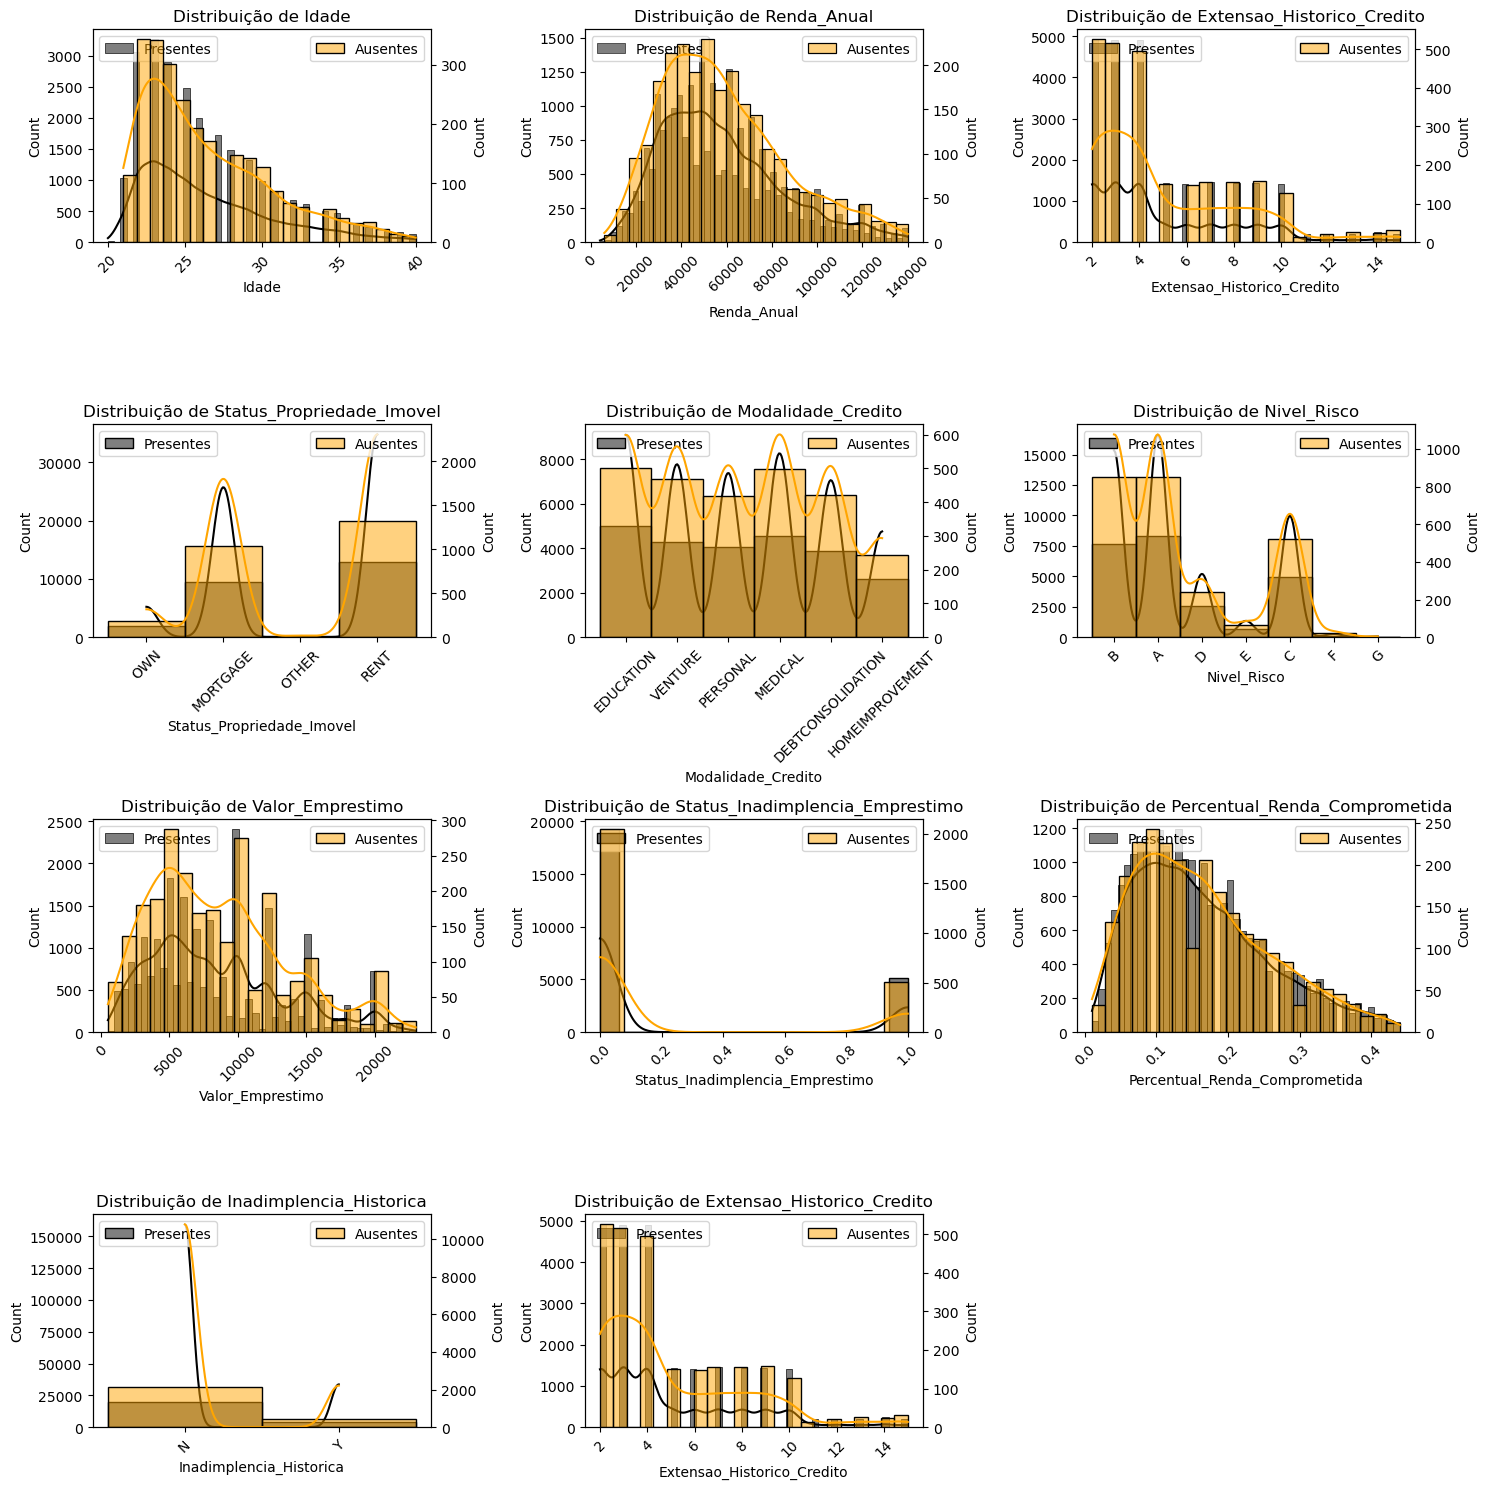

In [64]:
# Lista das variáveis a serem avaliadas.
vars_to_compare = ['Idade', 'Renda_Anual', 'Extensao_Historico_Credito', 'Status_Propriedade_Imovel', 'Modalidade_Credito', 'Nivel_Risco', 'Valor_Emprestimo', 'Status_Inadimplencia_Emprestimo', 'Percentual_Renda_Comprometida', 'Inadimplencia_Historica', 'Extensao_Historico_Credito']

# Define a figura e a grade de subgráficos.
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15)) 
axes = axes.flatten() # Torna o array de eixos unidimensional para facilitar o uso no loop.

# Remove o último eixo (para que fiquem 2 gráficos na última linha).
fig.delaxes(axes[-1])

# Loop para plotar as distribuições de cada variável.
for i, var in enumerate(vars_to_compare):
    if i < len(axes): # Verifican se há eixos suficientes.
        # Cria o primeiro eixo Y para a distribuição de 'B_missing == 0' (dados presentes).
        sns.histplot(df_geral_main[var][df_geral_main['B_missing'] == 0], kde=True, ax=axes[i], color='black', label='Presentes')
        axes[i].set_title(f'Distribuição de {var}')
        axes[i].legend(loc='upper left')

        # Cria o segundo eixo Y para a distribuição de 'B_missing == 1' (dados ausentes).
        ax2 = axes[i].twinx() # Cria o eixo Y secundário.
        sns.histplot(df_geral_main[var][df_geral_main['B_missing'] == 1], kde=True, ax=ax2, color='orange', label='Ausentes')
        ax2.legend(loc='upper right')

        # Gira as labels do eixo X.
        axes[i].tick_params(axis='x', rotation=45)

# Ajusta o layout para não sobrepor os gráficos.
plt.tight_layout()
plt.show()

In [65]:
# Reseta o índice para evitar erros.
df_geral_main = df_geral_main.reset_index(drop=True)

In [66]:
# Altera as coluna com dados no formato object para category, pois o algoritmo de imputação não aceita valores no formato object.
for col in df_geral_main.select_dtypes(include=['object']).columns:
    df_geral_main[col] = df_geral_main[col].astype('category')

In [67]:
# Cria o Kernel de Imputação.
kernel = mf.ImputationKernel(
    df_geral_main,  
    random_state=42  
)

# Realiza a imputação com 3 iterações.
kernel.mice(3)

# Obtém os dados imputados.
df_geral_main = kernel.complete_data()

# Mostra os dados após a imputação.
df_geral_main.head()

,Idade,Renda_Anual,Status_Propriedade_Imovel,Modalidade_Credito,Nivel_Risco,Valor_Emprestimo,Taxa_Juros,Status_Inadimplencia_Emprestimo,Percentual_Renda_Comprometida,Inadimplencia_Historica,Extensao_Historico_Credito,Permanencia_Emprego,A_missing,B_missing
0,21,9600,OWN,EDUCATION,B,1000,11.14,0,0.10,N,2,5.0,0,0
1,21,9900,OWN,VENTURE,A,2500,7.14,1,0.25,N,2,2.0,0,0
2,21,10000,OWN,VENTURE,D,1600,14.74,1,0.16,N,3,6.0,0,0
3,24,10800,MORTGAGE,EDUCATION,B,1750,10.99,1,0.16,N,2,8.0,0,0
4,24,10980,OWN,PERSONAL,A,1500,7.29,0,0.14,N,3,0.0,0,0


In [68]:
df_geral_main.drop(['A_missing', 'B_missing'], axis=1, inplace=True) # Exclui as colunas 'A_missing' e 'B_missing'.

In [69]:
df_geral_main.to_sql("credit_risk_dataset", con, if_exists="replace", index=False) # Salva o DataFrame em uma tabela do banco de dados.

26878

In [70]:
con.close()